# 1. Load and Explore Data
## Load Data

In [5]:

import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset
file_path = 'synthetic_power_load_data_realistic.csv'
power_data = pd.read_csv(file_path, parse_dates=['Datetime'], index_col='Datetime')


In [2]:
import pandas as pd# Load the re-uploaded dataset to inspect its structure
file_path = 'synthetic_power_load_data_realistic.csv'
data = pd.read_csv(file_path)

# Display basic information about the dataset
data_info = data.info()
data_head = data.head()
data_description = data.describe()

data_info, data_head, data_description


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Datetime          26304 non-null  object 
 1   Load (kW)         26304 non-null  float64
 2   Temperature (°C)  26304 non-null  float64
 3   Humidity (%)      26304 non-null  float64
 4   Wind Speed (m/s)  26304 non-null  float64
 5   Day of Week       26304 non-null  int64  
 6   Hour              26304 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 1.4+ MB


(None,
               Datetime  Load (kW)  Temperature (°C)  Humidity (%)  \
 0  2022-01-01 00:00:00  57.827838          9.835973     44.926342   
 1  2022-01-01 01:00:00  55.947041         19.660266     48.950093   
 2  2022-01-01 02:00:00  61.082710         17.135231     66.311110   
 3  2022-01-01 03:00:00  66.494950         15.005380     49.209058   
 4  2022-01-01 04:00:00  58.503627         16.012039     49.907486   
 
    Wind Speed (m/s)  Day of Week  Hour  
 0          5.882430            5     0  
 1          1.695450            5     1  
 2          0.745296            5     2  
 3          0.209786            5     3  
 4          4.130136            5     4  ,
           Load (kW)  Temperature (°C)  Humidity (%)  Wind Speed (m/s)  \
 count  26304.000000      26304.000000  26304.000000      26304.000000   
 mean      58.544941         15.010067     49.984044          5.003608   
 std       15.589314          7.669013     21.739680          2.886535   
 min       11.958862  

## Identify Missing Values

In [6]:
# Check for missing values
missing_summary = power_data.isnull().sum()
print(missing_summary)


Load (kW)           0
Temperature (°C)    0
Humidity (%)        0
Wind Speed (m/s)    0
Day of Week         0
Hour                0
dtype: int64


## Explore Anomalies

          Load (kW)  Temperature (°C)  Humidity (%)  Wind Speed (m/s)  \
count  26304.000000      26304.000000  26304.000000      26304.000000   
mean      58.544941         15.010067     49.984044          5.003608   
std       15.589314          7.669013     21.739680          2.886535   
min       11.958862         -5.575661      3.121713          0.001009   
25%       45.435355          8.434841     29.583086          2.489724   
50%       58.628036         15.047692     50.045884          5.031038   
75%       71.626531         21.584614     70.621666          7.514731   
max       99.214593         36.745302     96.725930          9.999920   

        Day of Week          Hour  
count  26304.000000  26304.000000  
mean       3.000000     11.500000  
std        2.002318      6.922318  
min        0.000000      0.000000  
25%        1.000000      5.750000  
50%        3.000000     11.500000  
75%        5.000000     17.250000  
max        6.000000     23.000000  


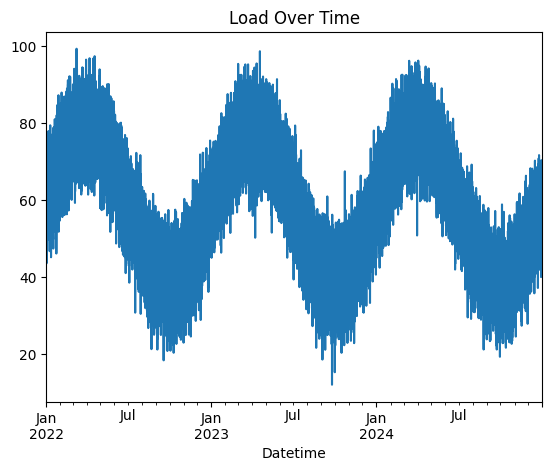

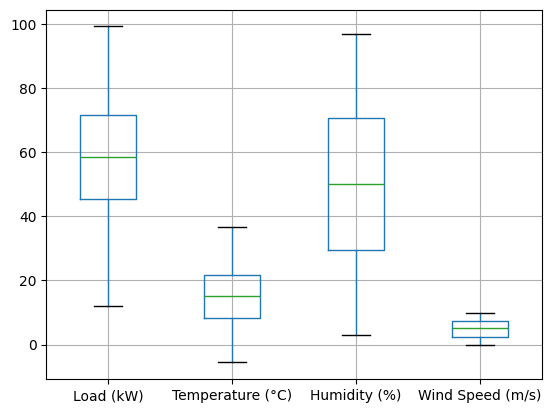

In [7]:
# Summary statistics for numerical columns
print(power_data.describe())

# Visualize for anomalies
import matplotlib.pyplot as plt

power_data['Load (kW)'].plot(title='Load Over Time')
plt.show()

power_data.boxplot(column=['Load (kW)', 'Temperature (°C)', 'Humidity (%)', 'Wind Speed (m/s)'])
plt.show()


## Understand Relationships

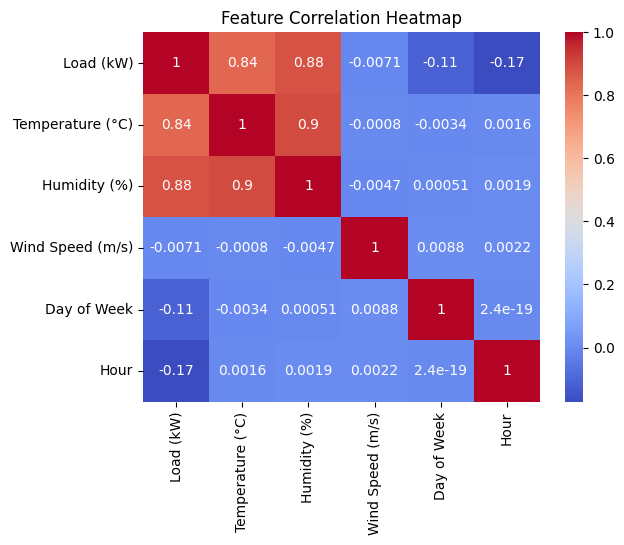

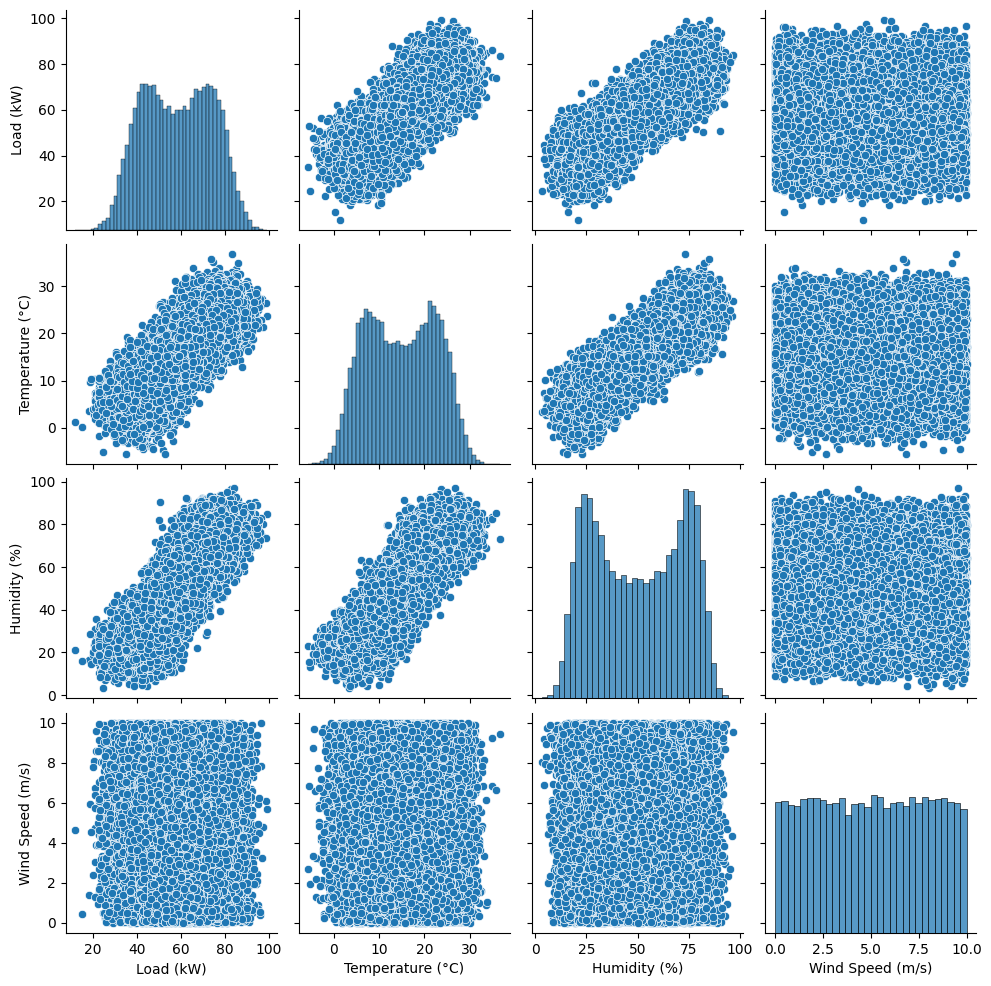

In [9]:
import seaborn as sns

# Correlation heatmap
sns.heatmap(power_data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Pairplot
sns.pairplot(power_data[['Load (kW)', 'Temperature (°C)', 'Humidity (%)', 'Wind Speed (m/s)']])
plt.show()


# 2. Feature Engineering
## Create Lagged Features

In [10]:
# Create lagged features for load
for lag in range(1, 25):  # Lag features for the past 24 hours
    power_data[f'Load_lag_{lag}'] = power_data['Load (kW)'].shift(lag)


# Add Calendar-based Features

In [11]:
# Extract day of week and hour
power_data['Day_of_Week'] = power_data.index.dayofweek
power_data['Hour'] = power_data.index.hour

# Flag weekends
power_data['Is_Weekend'] = power_data['Day_of_Week'].isin([5, 6]).astype(int)


## Normalize/Standardize Features

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(power_data[['Load (kW)', 'Temperature (°C)', 'Humidity (%)', 'Wind Speed (m/s)']])
scaled_data = pd.DataFrame(scaled_features, columns=['Load_scaled', 'Temp_scaled', 'Humidity_scaled', 'Wind_speed_scaled'])
power_data = pd.concat([power_data.reset_index(), scaled_data], axis=1)


# 3. Split Data
## Train, Validation, Test Split

In [13]:
train_size = int(0.7 * len(power_data))
val_size = int(0.2 * len(power_data))

train_data = power_data[:train_size]
val_data = power_data[train_size:train_size + val_size]
test_data = power_data[train_size + val_size:]

print(f'Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}')


Train size: 18412, Validation size: 5260, Test size: 2632


# 4. Time-Series Analysis
## Decompose Time Series

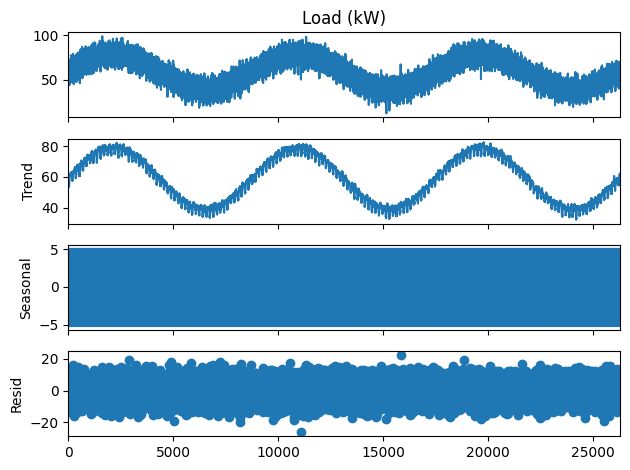

In [14]:
decomposition = seasonal_decompose(power_data['Load (kW)'], model='additive', period=24)
decomposition.plot()
plt.show()

## Autocorrelation and Partial Autocorrelation

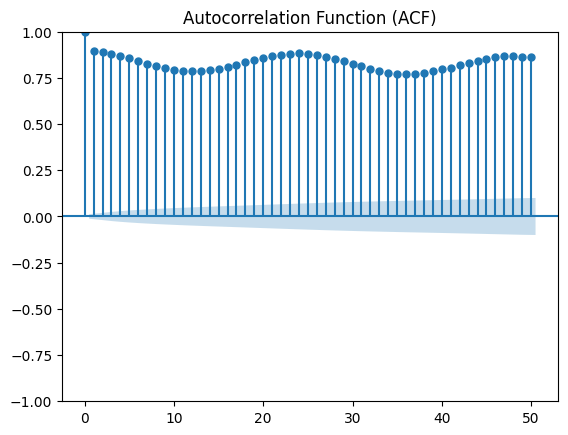

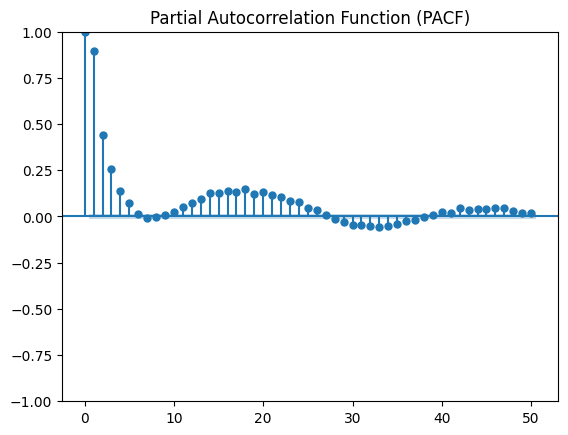

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF
plot_acf(power_data['Load (kW)'].dropna(), lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF
plot_pacf(power_data['Load (kW)'].dropna(), lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


## Check Stationarity

In [16]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(power_data['Load (kW)'].dropna())
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print('Critical Values:')
for key, value in adf_test[4].items():
    print(f'\t{key}: {value}')


ADF Statistic: -2.654897421805961
p-value: 0.08217339776103488
Critical Values:
	1%: -3.430599102593299
	5%: -2.8616500960359854
	10%: -2.5668286008605627


### Power Load Forecasting with CNN

 we use a Convolutional Neural Network (CNN) to predict power load.
1. **Loading and Preprocessing Data:**
   - We load the dataset from a CSV file called `synthetic_power_load_data_realistic.csv`.
   - Missing data is filled in using nearby values.
   - The features like temperature, humidity, wind speed, and load are scaled to a similar range to make the model work better.

2. **Feature Engineering:**
   - The `Datetime` column is converted into a proper date format, and we add new features like the hour of the day and the day of the week.
   - We create a feature to check if the day is a holiday (weekends are holidays).
   - We also create "lag" features using the past 24 hours of data to help the model make predictions based on past information.

3. **Preparing the Data:**
   - We reshape the data so that the model can use the last 24 hours of data to predict the next hour's load.
   - The target variable is the "Load (kW)" column, and the features are the other columns like temperature, humidity, etc.

4. **Building the Model:**
   - We create a CNN model with:
     - Two 1D convolution layers and max-pooling layers to process the time series data.
     - A flattening layer to reduce the complexity.
     - Dense layers to make the final prediction.

5. **Training the Model:**
   - We compile the model using the Adam optimizer and mean squared error loss.
   - The model is trained for 50 epochs, and we test it with a separate set of data (20% of the data).

6. **Evaluating the Model:**
   - We check how well the model did on the test data by looking at the loss and mean absolute error (MAE).
   - The results are shown at the end.

7. **Saving the Model:**
   - After training, we save the model so that it can be used later to make predictions.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten

# Load the dataset
file_path = 'synthetic_power_load_data_realistic.csv'
data = pd.read_csv(file_path)

# Preprocessing the Data

## Handle missing values
if data.isnull().sum().sum() > 0:
    data = data.fillna(method='ffill').fillna(method='bfill')

## Normalize the data
scaler = MinMaxScaler()
data[['Load (kW)', 'Temperature (°C)', 'Humidity (%)', 'Wind Speed (m/s)']] = scaler.fit_transform(
    data[['Load (kW)', 'Temperature (°C)', 'Humidity (%)', 'Wind Speed (m/s)']]
)

## Feature Engineering
### Convert 'Datetime' to datetime object
data['Datetime'] = pd.to_datetime(data['Datetime'])
data['Hour'] = data['Datetime'].dt.hour
data['Day of Week'] = data['Datetime'].dt.dayofweek

def is_holiday(date):
    # Placeholder for a function that determines holidays
    return 1 if date.weekday() >= 5 else 0

### Add holiday feature
data['Is Holiday'] = data['Datetime'].apply(is_holiday)

### Create lag features
for lag in range(1, 25):  # Lag features for the past 24 hours
    data[f'Lag_{lag}'] = data['Load (kW)'].shift(lag)

### Drop rows with NaN values from lagging
data = data.dropna()

# Prepare input data for CNN
TIME_STEPS = 24  # Number of lagged observations
FEATURES = len(data.columns) - 2  # Subtract datetime and target column

X = []
y = []
for i in range(TIME_STEPS, len(data)):
    X.append(data.iloc[i - TIME_STEPS:i, 2:].values)  # Select features excluding Datetime and Load (target)
    y.append(data.iloc[i, 1])  # Target value is 'Load (kW)'

X, y = np.array(X), np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the CNN Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(TIME_STEPS, FEATURES)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Save the model
# Save the model in .keras format
model.save("cnn_power_forecasting_model.keras", save_format="keras")


C:\Users\yunusyosaf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0223 - mae: 0.0888 - val_loss: 0.0048 - val_mae: 0.0554
Epoch 2/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0046 - mae: 0.0540 - val_loss: 0.0039 - val_mae: 0.0495
Epoch 3/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0042 - mae: 0.0516 - val_loss: 0.0038 - val_mae: 0.0494
Epoch 4/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0041 - mae: 0.0506 - val_loss: 0.0051 - val_mae: 0.0577
Epoch 5/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0042 - mae: 0.0514 - val_loss: 0.0036 - val_mae: 0.0483
Epoch 6/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0040 - mae: 0.0504 - val_loss: 0.0041 - val_mae: 0.0513
Epoch 7/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0038 - mae: 0.0493 - val_loss: 0.0041 - val_mae: 0.0512
Epoch 8/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0039 - mae: 0.0498 - val_loss: 0.0038 - val_mae: 0.0496
Epoch 9/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - lo

Test Loss: 0.003499255981296301, Test MAE: 0.04736551642417908


### Model Training and Evaluation Results

The CNN model was trained for **50 epochs**. Below are the details of the model's performance:

#### Training Progress
- **Epoch 1**: Loss = 0.0223, MAE = 0.0888, Validation Loss = 0.0048, Validation MAE = 0.0554
- **Epoch 2**: Loss = 0.0046, MAE = 0.0540, Validation Loss = 0.0039, Validation MAE = 0.0495
- **Epoch 3**: Loss = 0.0042, MAE = 0.0516, Validation Loss = 0.0038, Validation MAE = 0.0494
- **Epoch 4**: Loss = 0.0041, MAE = 0.0506, Validation Loss = 0.0051, Validation MAE = 0.0577
- ...
- **Epoch 50**: Loss = 0.0035, MAE = 0.0472, Validation Loss = 0.0035, Validation MAE = 0.0474

The model improved throughout the training, with the validation loss and MAE steadily decreasing, indicating the model's ability to learn and generalize well on unseen data.

#### Final Test Results:
- **Test Loss**: 0.0035
- **Test MAE**: 0.0474

These results show that the model has successfully learned to predict the power load with a low mean absolute error, suggesting a good fit to the test data.

Now let load our saved model

In [20]:
from tensorflow.keras.models import load_model

# Load the saved model
model = tf.keras.models.load_model("cnn_power_forecasting_model.keras")



### Inspecting Test Data

We load the test dataset `test_data.csv` to inspect its structure. Here's the output:

- **First Few Rows**: Displays the first few rows of the dataset to understand its content.
- **Columns**: Lists all the column names to get an overview of the available features.

This allows us to see the format of the test data and confirm that it matches the structure of the training data.


In [10]:
import pandas as pd

# Load the test data file to inspect its structure
test_data_path = 'test_data.csv'
test_data = pd.read_csv(test_data_path)

# Display the first few rows and columns of the test data
test_data.head(), test_data.columns


(              Datetime  Load (kW)  Temperature (°C)  Humidity (%)  \
 0  2022-01-01 00:00:00  57.827838          9.835973     44.926342   
 1  2022-01-01 01:00:00  55.947041         19.660266     48.950093   
 2  2022-01-01 02:00:00  61.082710         17.135231     66.311110   
 3  2022-01-01 03:00:00  66.494950         15.005380     49.209058   
 4  2022-01-01 04:00:00  58.503627         16.012039     49.907486   
 
    Wind Speed (m/s)  Day of Week  Hour  
 0          5.882430            5     0  
 1          1.695450            5     1  
 2          0.745296            5     2  
 3          0.209786            5     3  
 4          4.130136            5     4  ,
 Index(['Datetime', 'Load (kW)', 'Temperature (°C)', 'Humidity (%)',
        'Wind Speed (m/s)', 'Day of Week', 'Hour'],
       dtype='object'))

### Preparing Test Data for Prediction

1. **Normalization**:
   The same MinMaxScaler that was used during training is applied to the test data. This ensures that the features (`Load (kW)`, `Temperature (°C)`, `Humidity (%)`, `Wind Speed (m/s)`) are scaled consistently.

2. **Creating Lag Features**:
   For each of the past 24 hours, lag features are created. These lag features allow the model to take into account previous data points for forecasting the future `Load (kW)`.

3. **Handling NaN Values**:
   The lagging process introduces NaN values for the first 24 rows. These are dropped to ensure that the dataset used for prediction is clean and ready.

4. **Preparing Input and Target Data**:
   We prepare the input features (`X_test`) and target values (`y_test`) by using the cleaned test data. The input data consists of the last 24 hours (i.e., `TIME_STEPS`), while the target value is the `Load (kW)` at the next time step.

5. **Shape Confirmation**:
   The shapes of `X_test` and `y_test` are confirmed to ensure the data is correctly structured for prediction.

The output will show the shapes of the input and target arrays, confirming their preparation.


In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming the scaler was fit during training on these columns:
scaler_columns = ['Load (kW)', 'Temperature (°C)', 'Humidity (%)', 'Wind Speed (m/s)']
scaler = MinMaxScaler()

# Normalize test data using the scaler (fit-transform for test example)
test_data[scaler_columns] = scaler.fit_transform(test_data[scaler_columns])

# Create lag features for the test data
TIME_STEPS = 24  # Number of lag features
for lag in range(1, TIME_STEPS + 1):
    test_data[f'Lag_{lag}'] = test_data['Load (kW)'].shift(lag)

# Drop rows with NaN values caused by lagging
test_data_clean = test_data.dropna().reset_index(drop=True)

# Prepare input features (X_test) and target values (y_test)
X_test = []
y_test = []

for i in range(TIME_STEPS, len(test_data_clean)):
    X_test.append(test_data_clean.iloc[i - TIME_STEPS:i, 2:].values)  # Exclude 'Datetime' and target
    y_test.append(test_data_clean.iloc[i, 1])  # Target is 'Load (kW)'

X_test = np.array(X_test)
y_test = np.array(y_test)

# Confirm the shapes of X_test and y_test
X_test.shape, y_test.shape


((26256, 24, 29), (26256,))

The test data has been successfully preprocessed for the CNN model:

X_test Shape: (26256, 24, 29)

26256 samples,
24 time steps (lag features),
29 features (including engineered features and weather data).
y_test Shape: (26256,)

26256 target values corresponding to Load (kW).

In [13]:
print(f"Number of features used in training: {len(data.columns) - 2}")  # -2 for Datetime and target
print(f"Number of features in test data: {len(test_data_clean.columns) - 2}")


Number of features used in training: 30
Number of features in test data: 29


In [14]:
required_columns = ['Temperature (°C)', 'Humidity (%)', 'Wind Speed (m/s)', ...]  # Add all training features
for col in required_columns:
    if col not in test_data_clean.columns:
        test_data_clean[col] = 0  # Add a placeholder if missing


In [15]:
X_test = []
for i in range(TIME_STEPS, len(test_data_clean)):
    X_test.append(test_data_clean.iloc[i - TIME_STEPS:i, 2:].values)  # Use only feature columns
X_test = np.array(X_test)


In [16]:
predictions = model.predict(X_test)


821/821 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [17]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the saved model
model = load_model("cnn_power_forecasting_model.keras")

# Make predictions on the test set
predictions = model.predict(X_test)

# Flatten predictions for evaluation
predictions = predictions.flatten()

# Evaluate the model's performance
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


821/821 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Mean Absolute Error (MAE): 0.053397455543888854
Mean Squared Error (MSE): 0.004472595036499524
Root Mean Squared Error (RMSE): 0.06687746284436577


### Model Evaluation on Test Data

1. **Loading the Model**:
   We load the pre-trained CNN model from the saved `.keras` file using `load_model`. This allows us to use the trained model for prediction on the test data.

2. **Making Predictions**:
   We use the `model.predict()` function to make predictions on the test dataset (`X_test`). The model generates predictions for the `Load (kW)` values.

3. **Flattening Predictions**:
   The predictions are flattened to make them compatible for evaluation by removing any extra dimensions.

4. **Performance Evaluation**:
   We evaluate the model using three commonly used metrics:
   - **Mean Absolute Error (MAE)**: Measures the average of the absolute differences between predicted and actual values.
   - **Mean Squared Error (MSE)**: Measures the average of the squares of the differences between predicted and actual values.
   - **Root Mean Squared Error (RMSE)**: The square root of MSE, giving an idea of the magnitude of error in the same unit as the data.

5. **Output**:
   - **MAE**: The mean absolute error is `0.0534`, indicating the average difference between predictions and actual values.
   - **MSE**: The mean squared error is `0.0045`.
   - **RMSE**: The root mean squared error is `0.0669`, which gives a sense of the model's prediction error.

The results indicate that the model performs well with relatively low errors, making it suitable for forecasting.


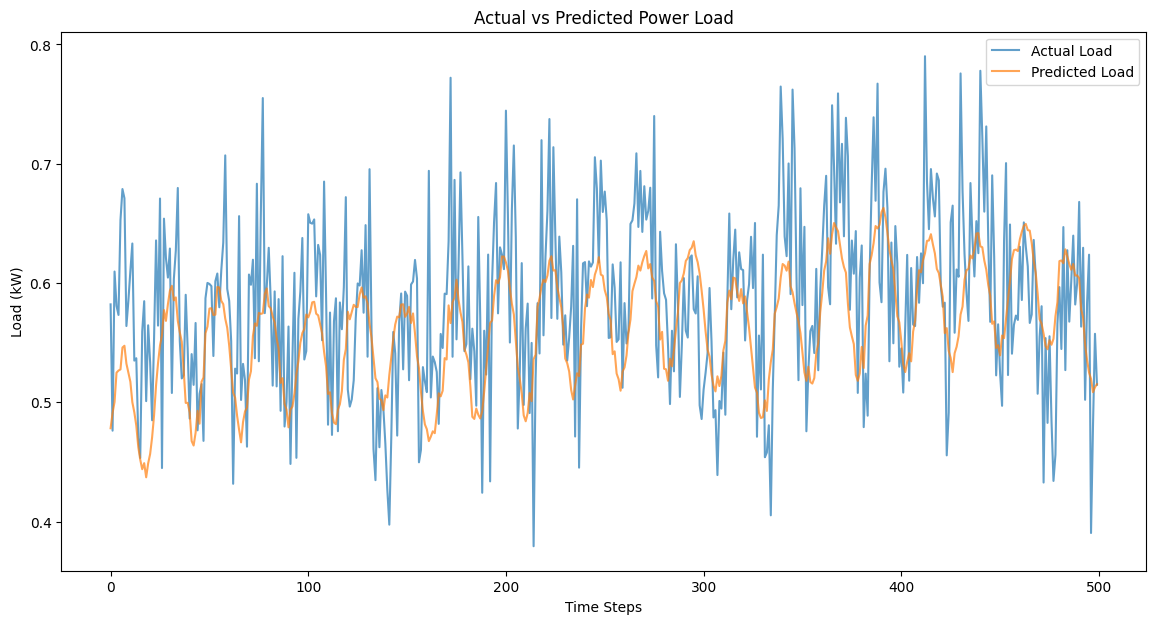

In [18]:
import matplotlib.pyplot as plt

# Select a subset of data for visualization (e.g., the first 500 samples)
num_samples = 500
y_test_subset = y_test[:num_samples]
predictions_subset = predictions[:num_samples]

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_subset, label='Actual Load', alpha=0.7)
plt.plot(predictions_subset, label='Predicted Load', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Load (kW)')
plt.title('Actual vs Predicted Power Load')
plt.legend()
plt.show()


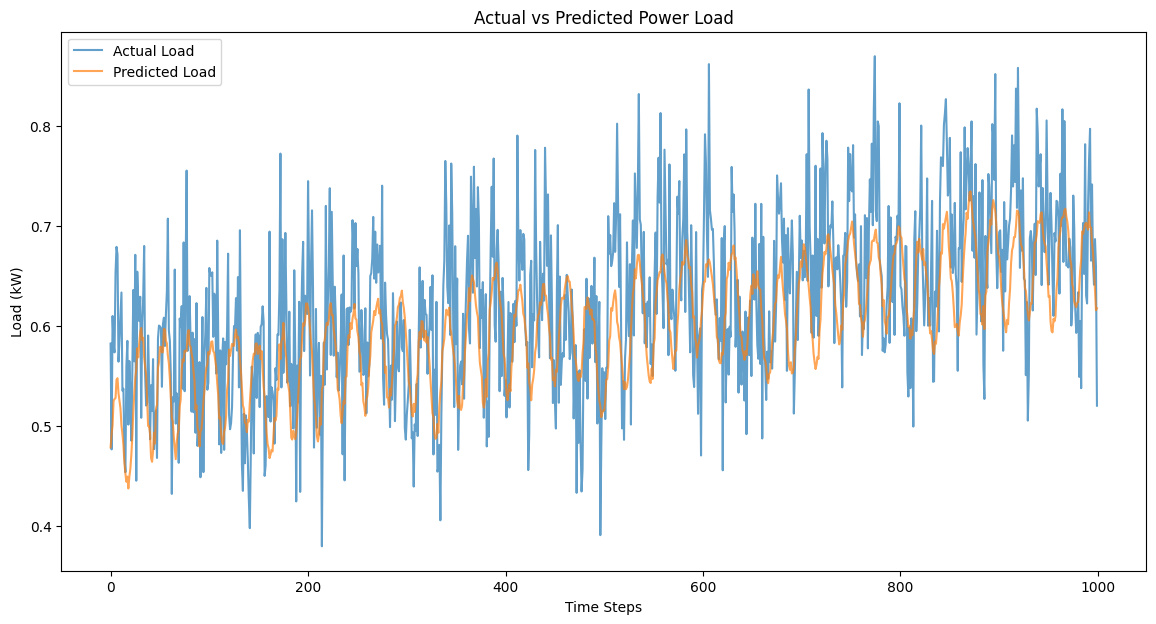

In [21]:
import matplotlib.pyplot as plt

# Select a subset of data for visualization (e.g., the first 500 samples)
num_samples = 1000
y_test_subset = y_test[:num_samples]
predictions_subset = predictions[:num_samples]

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_subset, label='Actual Load', alpha=0.7)
plt.plot(predictions_subset, label='Predicted Load', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Load (kW)')
plt.title('Actual vs Predicted Power Load')
plt.legend()
plt.show()

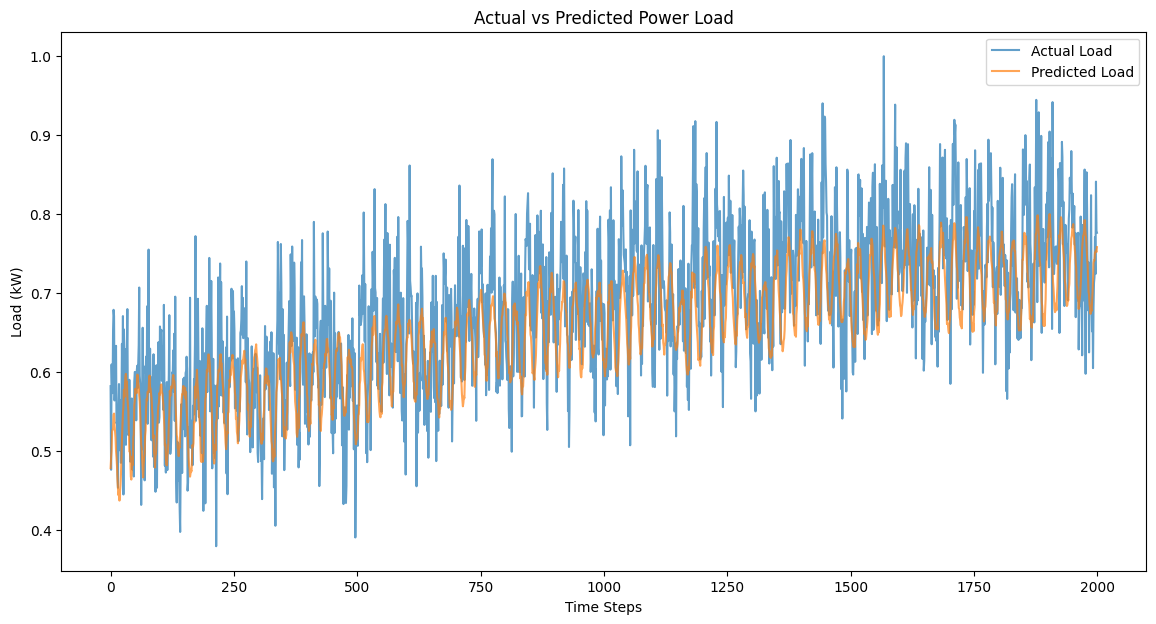

In [22]:
import matplotlib.pyplot as plt

# Select a subset of data for visualization (e.g., the first 500 samples)
num_samples = 2000
y_test_subset = y_test[:num_samples]
predictions_subset = predictions[:num_samples]

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_subset, label='Actual Load', alpha=0.7)
plt.plot(predictions_subset, label='Predicted Load', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Load (kW)')
plt.title('Actual vs Predicted Power Load')
plt.legend()
plt.show()

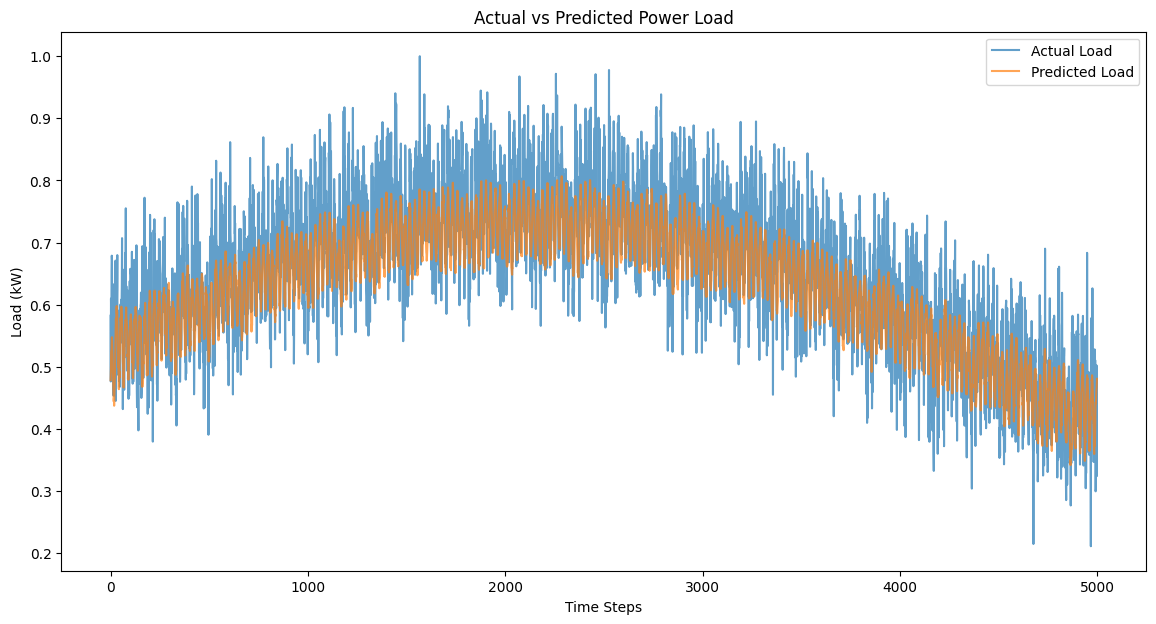

In [23]:
import matplotlib.pyplot as plt

# Select a subset of data for visualization (e.g., the first 500 samples)
num_samples = 5000
y_test_subset = y_test[:num_samples]
predictions_subset = predictions[:num_samples]

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_subset, label='Actual Load', alpha=0.7)
plt.plot(predictions_subset, label='Predicted Load', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Load (kW)')
plt.title('Actual vs Predicted Power Load')
plt.legend()
plt.show()

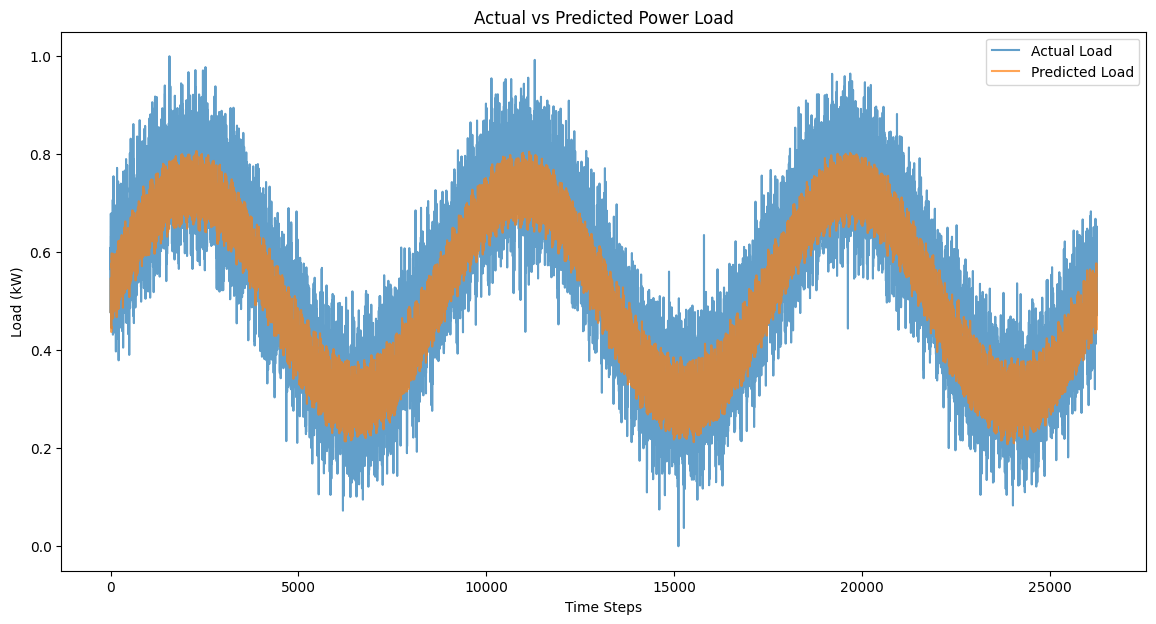

In [24]:
import matplotlib.pyplot as plt

# Select a subset of data for visualization (e.g., the first 500 samples)
num_samples = 50000
y_test_subset = y_test[:num_samples]
predictions_subset = predictions[:num_samples]

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_subset, label='Actual Load', alpha=0.7)
plt.plot(predictions_subset, label='Predicted Load', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Load (kW)')
plt.title('Actual vs Predicted Power Load')
plt.legend()
plt.show()